### Convert 3D volumetric data to 2D images in different folders of 0 and 1

In [1]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import helpers as H
from tqdm import tqdm

#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")
#train_data_paths = glob.glob(os.path.join(TRAIN_DATASET_PATH,'img_datas_1','*.npy'))
train_data_paths = os.listdir(os.path.join(TRAIN_DATASET_PATH, "img_datas_1"))
print(len(train_data_paths))


218


In [26]:
%matplotlib inline
import sys
import numpy as np
from numpy import *
from scipy import stats
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import *
import glob
from sklearn.model_selection import train_test_split
import datetime
import math
import os.path
from importlib import reload
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from multiprocessing import Pool
import time
from skimage import measure, morphology, segmentation
import scipy.ndimage as ndimage
import dicom

C:\Users\Aiman\Anaconda3\envs\sticker\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Aiman\Anaconda3\envs\sticker\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
def to_3D(arr, resize_dim=None):
    '''Stack 2D slice to add dummy 3-channel dimension'''
    img = np.asarray(np.dstack((arr, arr, arr)), dtype=np.float64)
    if resize_dim is not None:
        img=cv2.resize(img,(resize_dim, resize_dim),interpolation=cv2.INTER_AREA)    
    else:
        pass
    return img

In [3]:
def get_number(filename):
    return int(filename[:filename.find('.')])

def sort_paths(paths):
    paths.sort(key = get_number)
    return paths

In [4]:
train_data_paths[:4]

['1.npy', '10.npy', '100.npy', '101.npy']

In [5]:
sort_paths(train_data_paths)[:5]

['1.npy', '2.npy', '3.npy', '4.npy', '5.npy']

In [6]:
y_train = np.load("y_train_clef.npy")
y_train.shape

(218, 2)

In [7]:
y_train_flat = np.array([np.argmax(x) for x in y_train])
y_train_flat.shape

(218,)

In [8]:
y_train_flat

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
      dtype=int64)

### Test before and after saving slices

In [16]:
img = np.load("{}/img_datas_1/{}".format(TRAIN_DATASET_PATH, "1.npy"))
img.shape

(512, 512, 128)

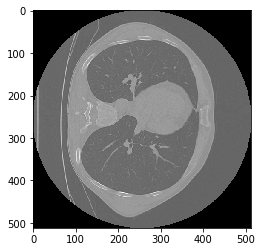

In [17]:
plt.imshow(img[:,:,55], cmap='gray')

-3024.0 2367.0


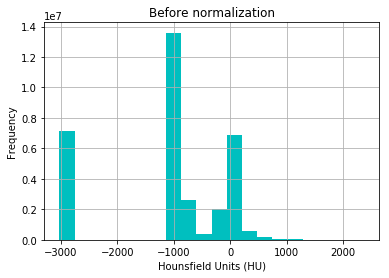

In [18]:
img_flat = img.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Hounsfield Units (HU)")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [28]:
exp = np.transpose(img, (2, 0, 1))
exp.shape

(128, 512, 512)

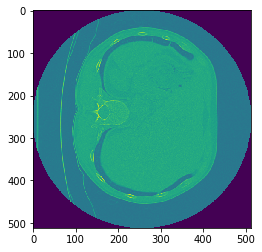

In [29]:
plt.imshow(exp[10,:,:])

In [45]:
THRESHOLD_HIGH = 700
THRESHOLD_LOW = -1100

def seperate_lungs_and_pad(scan):
    
    # make total 256 slices fill in -1100 as exterme value 
    slices = scan.shape[0]
    segmented_scan = np.full ((slices, 512, 512), THRESHOLD_LOW)
    
    for i, image in enumerate (scan):
        
        # Ignore all slices later than 255 if required.
        if (i == slices):
            break
        
        # Creation of the internal Marker
        marker_internal = image < -400
        marker_internal = segmentation.clear_border(marker_internal)
        marker_internal_labels = measure.label(marker_internal)
        areas = [r.area for r in measure.regionprops(marker_internal_labels)]
        areas.sort()
        if len(areas) > 2:
            for region in measure.regionprops(marker_internal_labels):
                if region.area < areas[-2]:
                    for coordinates in region.coords:                
                           marker_internal_labels[coordinates[0], coordinates[1]] = 0
        marker_internal = marker_internal_labels > 0
        #Creation of the external Marker
        external_a = ndimage.binary_dilation(marker_internal, iterations=10)
        external_b = ndimage.binary_dilation(marker_internal, iterations=55)
        marker_external = external_b ^ external_a
        #Creation of the Watershed Marker matrix
        marker_watershed = np.zeros((512, 512), dtype=np.int)
        marker_watershed += marker_internal * 255
        marker_watershed += marker_external * 128

        #Creation of the Sobel-Gradient
        sobel_filtered_dx = ndimage.sobel(image, 1)
        sobel_filtered_dy = ndimage.sobel(image, 0)
        sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
        sobel_gradient *= 255.0 / np.max(sobel_gradient)

        #Watershed algorithm
        watershed = morphology.watershed(sobel_gradient, marker_watershed)

        #Reducing the image created by the Watershed algorithm to its outline
        outline = ndimage.morphological_gradient(watershed, size=(3,3))
        outline = outline.astype(bool)

        #Performing Black-Tophat Morphology for reinclusion
        #Creation of the disk-kernel and increasing its size a bit
        blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                           [0, 1, 1, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1],
                           [1, 1, 1, 1, 1, 1, 1],
                           [0, 1, 1, 1, 1, 1, 0],
                           [0, 0, 1, 1, 1, 0, 0]]
        blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
        #Perform the Black-Hat
        outline += ndimage.black_tophat(outline, structure=blackhat_struct)

        #Use the internal marker and the Outline that was just created to generate the lungfilter
        lungfilter = np.bitwise_or(marker_internal, outline)
        #Close holes in the lungfilter
        #fill_holes is not used here, since in some slices the heart would be reincluded by accident
        lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)

        #Apply the lungfilter (note the filtered areas being assigned 30 HU)
        segmented_scan[i] = np.where(lungfilter == 1, image, 30*np.ones((512, 512)))
        
    return segmented_scan

In [46]:
exp.shape

(128, 512, 512)

In [47]:
exp_res = seperate_lungs_and_pad(exp)
exp_res.shape

(128, 512, 512)

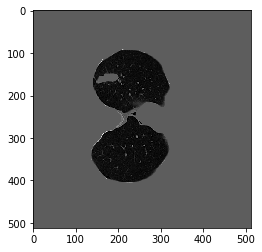

In [48]:
plt.imshow(exp_res[100,:,:], cmap='gray')

In [43]:
def threshold_and_normalize_scan (scan):
    scan = scan.astype(np.float32)
    scan [scan < THRESHOLD_LOW] = THRESHOLD_LOW
    scan [scan > THRESHOLD_HIGH] = THRESHOLD_HIGH
    
    # Maximum absolute value of any pixel .
    max_abs = abs (max(THRESHOLD_LOW, THRESHOLD_HIGH, key=abs))
    
    # This will bring values between -1 and 1
    scan /= max_abs
    
    return scan

In [44]:
a = threshold_and_normalize_scan(exp_res)
a.shape

(128, 512, 512)

In [ ]:
plt.imshow(exp_res[100,:,:], cmap='gray')

In [ ]:
img_norm = H.normalize(img)
img_norm.shape

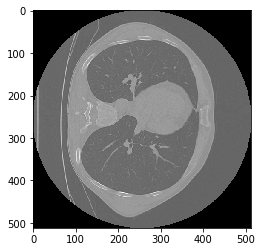

In [13]:
plt.imshow(img_norm[:,:,55], cmap='gray')

0.0 1.0


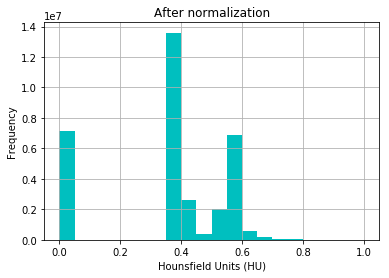

In [14]:
img_flat = img_norm.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("After normalization")
plt.xlabel("Hounsfield Units (HU)")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [15]:
img_norm.shape

(512, 512, 128)

In [16]:
x = H.center_crop(img_norm[:,:,55], (320, 320))
x.shape

(320, 320)

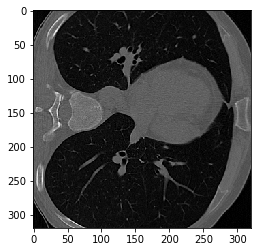

In [17]:
plt.imshow(x, cmap='gray')

In [18]:
a = img_norm[:,:,55]
a[250:252, 300:305]

array([[0.55240214, 0.573363  , 0.56445926, 0.55592656, 0.5475793 ],
       [0.55592656, 0.5676127 , 0.55759597, 0.54535335, 0.54275644]],
      dtype=float32)

In [19]:
cv2.imwrite("test.png", a * 255)

True

In [20]:
x = cv2.imread("test.png", 0)
x = x/255.0
x[250:252, 300:305]

array([[0.55294118, 0.57254902, 0.56470588, 0.55686275, 0.54901961],
       [0.55686275, 0.56862745, 0.55686275, 0.54509804, 0.54117647]])

In [21]:
!rm "test.png"

In [26]:
low_paths = os.path.join(TRAIN_DATASET_PATH, "2D_images/0")
high_paths = os.path.join(TRAIN_DATASET_PATH, "2D_images/1")
low_paths, high_paths

('/home/hasib/ecir2020/2D/dataset/2D_images/0',
 '/home/hasib/ecir2020/2D/dataset/2D_images/1')

In [27]:
H.create_directory(os.path.join(low_paths))
H.create_directory(os.path.join(high_paths))

In [28]:
x_train_2D = []
y_train_2D = []

img_number = 1
for array_path, label in zip(sort_paths(train_data_paths)[:5], y_train_flat):
    img = np.load("{}/img_datas_1/{}".format(TRAIN_DATASET_PATH, array_path))
    print(array_path, "-----", img.shape, "---", label)
    
    slice_number = img.shape[-1]
    if label == 0:
        for slc in range(slice_number):
            
            # Save all slices as numpy array
            #x_train_2D.append(img[:,:,slc])
            #y_train_2D.append(0)
            
            # 0 folder
            #np.save("{}/{}_{}.npy".format(low_paths, img_number, slc), img[:,:,slc]) 
            
            img_slc = H.normalize(img[:,:,slc]) # Normalize image
            img_slc = H.center_crop(img_slc, (299, 299))
            cv2.imwrite("{}/{}_{}.png".format(low_paths, img_number, slc),img_slc * 255)
            img_slc = None
            
    else:
        for slc in range(slice_number):
            
            # Save all slices as numpy array
            #x_train_2D.append(img[:,:,slc])
            #y_train_2D.append(1)
            
            # 1 folder
            #np.save("{}/{}_{}.npy".format(high_paths, img_number, slc), img[:,:,slc])
            
            img_slc = H.normalize(img[:,:,slc]) # Normalize image
            img_slc = H.center_crop(img_slc, (299, 299))
            cv2.imwrite("{}/{}_{}.png".format(high_paths, img_number, slc),img_slc * 255)
            img_slc = None
    
    img_number+=1

1.npy ----- (512, 512, 128) --- 0
2.npy ----- (512, 512, 122) --- 0
3.npy ----- (512, 512, 113) --- 0
4.npy ----- (512, 512, 120) --- 0
5.npy ----- (512, 512, 116) --- 1


### Remember to rescale using img/255.0 after loading images

```
img = cv2.imread("test.png", 0)
img = x/255.0 # Rescale to 0-1
```

In [29]:
len(os.listdir(low_paths)), len(os.listdir(high_paths))

(483, 116)

In [30]:
#x_train_2D = np.array(x_train_2D)
#y_train_2D = np.array(y_train_2D)
#x_train_2D.shape, y_train_2D.shape

In [31]:
#np.count_nonzero(y_train_2D == 1), np.count_nonzero(y_train_2D == 0)

In [32]:
a = y_train_flat[196:]
len(a)

22

In [33]:
np.count_nonzero(a == 1), np.count_nonzero(a == 0)

(11, 11)